In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torch.utils import data
import os
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available:
    device_name = torch.cuda.get_device_name(0)
    print(device_name)
print(f"Using device: {device}")



NVIDIA GeForce RTX 4050 Laptop GPU
Using device: cuda:0


In [2]:
# Load and transform the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the images
])

# Preprocessing
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

val_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
 # Define Multi-layer Perceptron
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 512)  # CIFAR-10 images are 3x32x32
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)   # 10 classes
        
    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define Multi-Layer Perceptron with increase in hidden layers
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 1024)  # CIFAR-10 images are 3x32x32
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 10)   # 10 classes
        
    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x


In [4]:
def model_train_val(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, train_accuracies, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses, train_accuracies, val_accuracies, model

Epoch 1/50, Training Loss: 1.6568, Training Accuracy: 40.95%, Validation Accuracy: 47.36%
Epoch 2/50, Training Loss: 1.4365, Training Accuracy: 49.25%, Validation Accuracy: 50.06%
Epoch 3/50, Training Loss: 1.3165, Training Accuracy: 53.48%, Validation Accuracy: 52.17%
Epoch 4/50, Training Loss: 1.2209, Training Accuracy: 56.72%, Validation Accuracy: 52.89%
Epoch 5/50, Training Loss: 1.1408, Training Accuracy: 59.29%, Validation Accuracy: 53.00%
Epoch 6/50, Training Loss: 1.0648, Training Accuracy: 62.06%, Validation Accuracy: 53.33%
Epoch 7/50, Training Loss: 0.9926, Training Accuracy: 64.32%, Validation Accuracy: 54.45%
Epoch 8/50, Training Loss: 0.9189, Training Accuracy: 67.10%, Validation Accuracy: 53.67%
Epoch 9/50, Training Loss: 0.8566, Training Accuracy: 69.18%, Validation Accuracy: 54.08%
Epoch 10/50, Training Loss: 0.7859, Training Accuracy: 71.69%, Validation Accuracy: 54.28%
Epoch 11/50, Training Loss: 0.7301, Training Accuracy: 73.83%, Validation Accuracy: 53.77%
Epoch 12

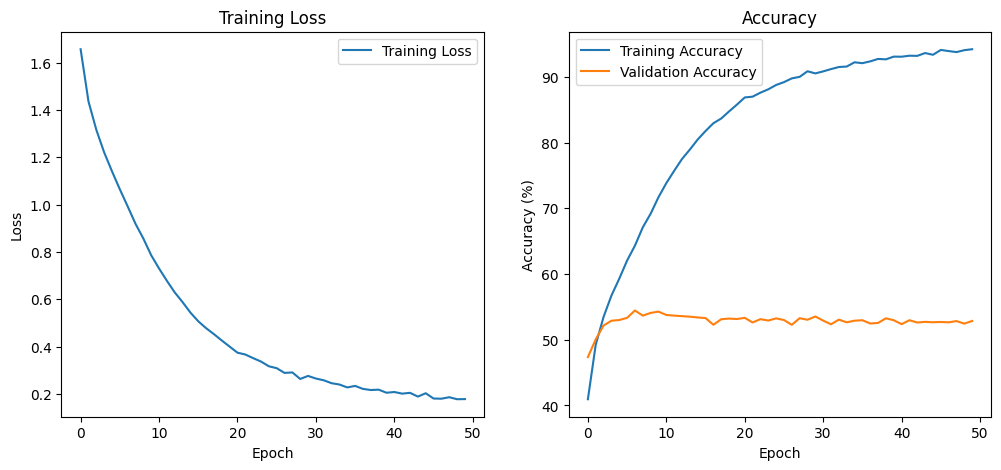

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [5]:
# PROBLEM 1a

# Instantiate the model
model = MLP().to(device, non_blocking=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies, val_accuracies = [], [], []

train_losses, train_accuracies, val_accuracies, model = model_train_val(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader
)
# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()





In [ ]:
# Calculate and report precision, recall, F1 score, and confusion matrix on validation set
y_pred, y_true = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

Epoch 1/50, Training Loss: 1.7281, Training Accuracy: 37.70%, Validation Accuracy: 44.88%
Epoch 2/50, Training Loss: 1.4945, Training Accuracy: 47.17%, Validation Accuracy: 46.65%
Epoch 3/50, Training Loss: 1.3645, Training Accuracy: 51.93%, Validation Accuracy: 50.88%
Epoch 4/50, Training Loss: 1.2630, Training Accuracy: 55.39%, Validation Accuracy: 51.43%
Epoch 5/50, Training Loss: 1.1786, Training Accuracy: 58.45%, Validation Accuracy: 52.90%
Epoch 6/50, Training Loss: 1.0940, Training Accuracy: 61.25%, Validation Accuracy: 54.56%
Epoch 7/50, Training Loss: 1.0130, Training Accuracy: 64.08%, Validation Accuracy: 54.45%
Epoch 8/50, Training Loss: 0.9356, Training Accuracy: 66.57%, Validation Accuracy: 54.11%
Epoch 9/50, Training Loss: 0.8647, Training Accuracy: 69.09%, Validation Accuracy: 55.11%
Epoch 10/50, Training Loss: 0.7880, Training Accuracy: 71.71%, Validation Accuracy: 55.29%
Epoch 11/50, Training Loss: 0.7238, Training Accuracy: 74.27%, Validation Accuracy: 53.91%
Epoch 12

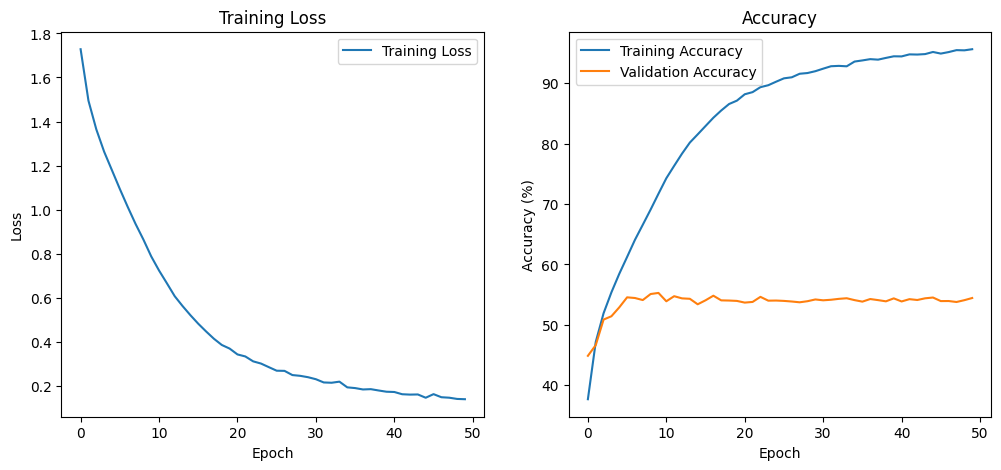

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# PROBLME 1b

# Instantiate the model
model2 = MLP2().to(device, non_blocking=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses2, train_accuracies2, val_accuracies2 = [], [], []

train_losses2, train_accuracies2, val_accuracies2, model2 = model_train_val(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader
)
# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses2, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies2, label='Training Accuracy')
plt.plot(val_accuracies2, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()





In [ ]:
# Calculate and report precision, recall, F1 score, and confusion matrix on validation set
y_pred2, y_true2 = [], []
model2.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

print(classification_report(y_true2, y_pred2))
print(confusion_matrix(y_true2, y_pred2))

Epoch[1/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[2/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[3/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[4/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[5/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[6/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[7/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[8/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[9/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[10/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[11/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[12/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[13/40], Train Loss: nan, Validation Loss: nan, Validation RMSE: nan
Epoch[14/40], Train Loss: nan, Validation Loss:

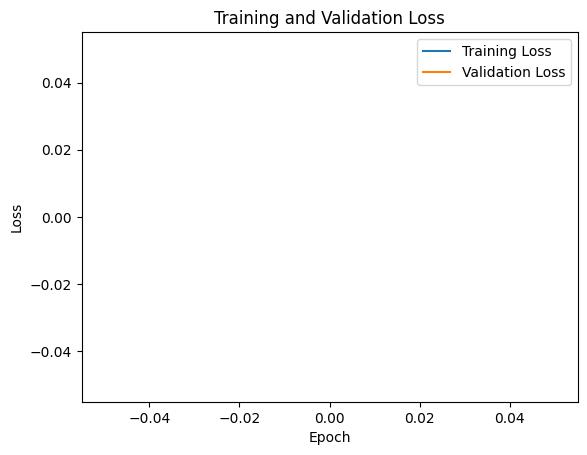

Final Validation RMSE: nan


In [2]:
# PROBLEM 2a

# Load file
file_path = '/home/csalitre/school/machine-learning/ECGR-5106/code/Datasets/house-train.csv'
df_train = pd.DataFrame(pd.read_csv(file_path))


features = ['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
             'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
            'GrLivArea',  'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
            'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
            'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

X = df_train[features].values
Y = df_train[['SalePrice']].values.reshape(-1,1)


# Split the data into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for train and validation sets
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

#Definition of network model class
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 500)  # 6 input features
        self.fc2 = nn.Linear(500, 20)
        self.fc3 = nn.Linear(20, 1)  # Output layer with 2 units for width and height

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

# Model, loss function, and optimizer
# Initialize the network
model = RegressionNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)



train_loss_list = []
val_loss_list = []

num_epochs = 40
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear existing gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update model parameters
        train_loss += loss.item() * inputs.size(0)  # Accumulate the loss

    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_total = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            val_loss += loss.item() * inputs.size(0)  # Accumulate the loss
            val_total += ((outputs - targets) ** 2).sum().item()  # Accumulate squared errors

    # Calculate average validation loss (MSE) and RMSE
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)
    rmse = np.sqrt(val_total / len(val_loader.dataset))

    # Print training and validation results
    print(f'Epoch[{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation RMSE: {rmse:.4f}')

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('temp/regression_loss_plot.png')
plt.show()

# Print final RMSE
print(f'Final Validation RMSE: {rmse:.4f}')


In [3]:
# Preprocessing 

# Check data type
pd.options.display.max_rows=90
df_dtype = pd.DataFrame(df_train.dtypes,columns=['dtype'])
print(df_dtype.value_counts())
print(df_dtype)

# Features used to modeling
usefull_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'
                , 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces'
                ,'LotFrontage','WoodDeckSF','OpenPorchSF'
                ,'ExterQual','Neighborhood','MSZoning'
                ,'Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition',]
df_train_prepro = df_train[usefull_cols].copy()


# One-hot encoding
df_train_prepro = pd.get_dummies(df_train_prepro,columns=['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition'])

#One-hot encoding: convert categorical data variables into a form that could be provided to machine learning.
#It creates binary (0 or 1) columns for each category in the original data.
#pd.get_dummies(): Tconverts categorical variable(s) into dummy/indicator variables.

df_train_prepro = df_train_prepro.replace({True: 1, False: 0})

# Convert all columns to numeric (float) and handle NaN values
df_train_prepro = df_train_prepro.apply(pd.to_numeric, errors='coerce').fillna(0)

# Save the DataFrame to a CSV file
output_directory = 'temp'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
output_file = 'temp/housing_df_train_prepro.csv'
df_train_prepro.to_csv(output_file, index=False)
print(f'DataFrame saved to {output_file}')

dtype  
object     43
int64      35
float64     3
Name: count, dtype: int64
                 dtype
Id               int64
MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
Street          object
Alley           object
LotShape        object
LandContour     object
Utilities       object
LotConfig       object
LandSlope       object
Neighborhood    object
Condition1      object
Condition2      object
BldgType        object
HouseStyle      object
OverallQual      int64
OverallCond      int64
YearBuilt        int64
YearRemodAdd     int64
RoofStyle       object
RoofMatl        object
Exterior1st     object
Exterior2nd     object
MasVnrType      object
MasVnrArea     float64
ExterQual       object
ExterCond       object
Foundation      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinSF1       int64
BsmtFinType2    object
BsmtFinSF2       int64
BsmtUnfSF        int64
TotalBsmtSF      int64
Heat

In [4]:
# Load the CSV file into a DataFrame
df_loaded = pd.read_csv(output_file)

# Display the first few rows of the loaded DataFrame to confirm it's loaded correctly
df_loaded.head()


,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,Fireplaces,LotFrontage,WoodDeckSF,...,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,7,1710,548,856,2,2003,2003,0,65.0,0,...,0,0,1,0,0,0,0,0,1,0
1,6,1262,460,1262,2,1976,1976,1,80.0,298,...,0,0,0,0,0,0,0,0,1,0
2,7,1786,608,920,2,2001,2002,1,68.0,0,...,0,0,1,0,0,0,0,0,1,0
3,7,1717,642,756,1,1915,1970,1,60.0,0,...,0,0,0,0,1,0,0,0,0,0
4,8,2198,836,1145,2,2000,2000,1,84.0,192,...,0,0,1,0,0,0,0,0,1,0


Epoch[1/40], Train Loss: 38243591266.1918, Validation Loss: 37718939619.9452, Validation RMSE: 194213.6443
Epoch[2/40], Train Loss: 33345325785.4247, Validation Loss: 28605925880.9863, Validation RMSE: 169132.8646
Epoch[3/40], Train Loss: 19704079598.4658, Validation Loss: 11695358407.8904, Validation RMSE: 108145.0804
Epoch[4/40], Train Loss: 5817187587.5068, Validation Loss: 4330599999.1233, Validation RMSE: 65807.2944
Epoch[5/40], Train Loss: 3318301131.3973, Validation Loss: 4191918721.7534, Validation RMSE: 64745.0285
Epoch[6/40], Train Loss: 3259253693.3699, Validation Loss: 4110005367.2329, Validation RMSE: 64109.3236
Epoch[7/40], Train Loss: 3213208553.2055, Validation Loss: 4021452522.9589, Validation RMSE: 63414.9235
Epoch[8/40], Train Loss: 3140451620.8219, Validation Loss: 3933159739.6164, Validation RMSE: 62714.9084
Epoch[9/40], Train Loss: 3071466546.8493, Validation Loss: 3831262141.3699, Validation RMSE: 61897.1901
Epoch[10/40], Train Loss: 3016458227.7260, Validation L

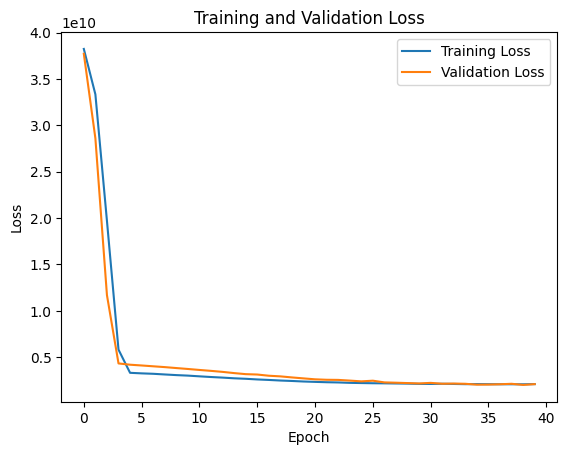

Final Validation RMSE: 45829.0011


In [ ]:
# Extract the value from the data set
x = df_loaded.iloc[:,0:79].values
y = df_train.iloc[:,80].values.reshape(-1,1)
#y[:5]

# Split the data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for train and validation sets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

#Definition of network model class
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(x_train.shape[1], 500)  # 6 input features
        self.fc2 = nn.Linear(500, 20)
        self.fc3 = nn.Linear(20, 1)  # Output layer with 2 units for width and height

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

# Model, loss function, and optimizer
# Initialize the network
model = RegressionNet().to(device, non_blocking=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



train_loss_list = []
val_loss_list = []

num_epochs = 40
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad()  # Clear existing gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update model parameters
        train_loss += loss.item() * inputs.size(0)  # Accumulate the loss

    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_total = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            val_loss += loss.item() * inputs.size(0)  # Accumulate the loss
            val_total += ((outputs - targets) ** 2).sum().item()  # Accumulate squared errors

    # Calculate average validation loss (MSE) and RMSE
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)
    rmse = np.sqrt(val_total / len(val_loader.dataset))

    # Print training and validation results
    print(f'Epoch[{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation RMSE: {rmse:.4f}')

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('temp/regression_loss_plot.png')
plt.show()

# Print final RMSE
print(f'Final Validation RMSE: {rmse:.4f}')

In [ ]:
# PROBLEM 2b
# Extract the value from the data set
x = df_loaded.iloc[:,0:79].values
y = df_train.iloc[:,80].values.reshape(-1,1)
#y[:5]

# Split the data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for train and validation sets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

#Definition of network model class
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(x_train.shape[1], 500)  # 6 input features
        self.fc2 = nn.Linear(500, 20)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(64, 20)
        self.fc3 = nn.Linear(20, 1)  # Output layer with 2 units for width and height

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

# Model, loss function, and optimizer
# Initialize the network
model = RegressionNet().to(device, non_blocking=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



train_loss_list = []
val_loss_list = []

num_epochs = 40
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad()  # Clear existing gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update model parameters
        train_loss += loss.item() * inputs.size(0)  # Accumulate the loss

    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_total = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            val_loss += loss.item() * inputs.size(0)  # Accumulate the loss
            val_total += ((outputs - targets) ** 2).sum().item()  # Accumulate squared errors

    # Calculate average validation loss (MSE) and RMSE
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)
    rmse = np.sqrt(val_total / len(val_loader.dataset))

    # Print training and validation results
    print(f'Epoch[{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation RMSE: {rmse:.4f}')

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('temp/regression_loss_plot.png')
plt.show()

# Print final RMSE
print(f'Final Validation RMSE: {rmse:.4f}')


Epoch[1/40], Train Loss: 38730228946.4110, Validation Loss: 38797757313.7534, Validation RMSE: 196971.4632
Epoch[2/40], Train Loss: 34775877267.2877, Validation Loss: 28810300037.2603, Validation RMSE: 169735.9715
Epoch[3/40], Train Loss: 18492809945.4247, Validation Loss: 9555167821.1507, Validation RMSE: 97750.5387
Epoch[4/40], Train Loss: 7382735528.3288, Validation Loss: 5371903256.5479, Validation RMSE: 73293.2688
Epoch[5/40], Train Loss: 4360248337.5342, Validation Loss: 3269607414.3562, Validation RMSE: 57180.4811
Epoch[6/40], Train Loss: 2837743805.3699, Validation Loss: 2555125146.3014, Validation RMSE: 50548.2457
Epoch[7/40], Train Loss: 2291924841.2055, Validation Loss: 2288188672.8767, Validation RMSE: 47835.0151
Epoch[8/40], Train Loss: 2017087500.2740, Validation Loss: 2161651796.1644, Validation RMSE: 46493.5673
Epoch[9/40], Train Loss: 1778659035.1781, Validation Loss: 2036422006.3562, Validation RMSE: 45126.7327
Epoch[10/40], Train Loss: 1618798272.8767, Validation Los

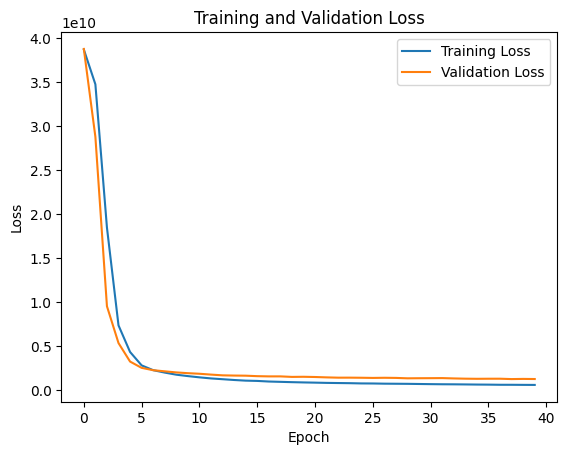

Final Validation RMSE: 35855.6357


In [7]:
# PROBLEM 2c

# Extract the value from the data set
x = df_loaded.iloc[:,0:79].values
y = df_train.iloc[:,80].values.reshape(-1,1)
#y[:5]

# Split the data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


scaler2 = StandardScaler()
scaler2_y = StandardScaler()

x_train = scaler2.fit_transform(x_train)
x_val = scaler2.transform(x_val)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for train and validation sets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

#Definition of network model class
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(x_train.shape[1], 500)  # 6 input features
        self.fc2 = nn.Linear(500, 20)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(64, 20)
        self.fc3 = nn.Linear(20, 1)  # Output layer with 2 units for width and height

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

# Model, loss function, and optimizer
# Initialize the network
model = RegressionNet().to(device, non_blocking=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



train_loss_list = []
val_loss_list = []

num_epochs = 40
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad()  # Clear existing gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update model parameters
        train_loss += loss.item() * inputs.size(0)  # Accumulate the loss

    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_total = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            val_loss += loss.item() * inputs.size(0)  # Accumulate the loss
            val_total += ((outputs - targets) ** 2).sum().item()  # Accumulate squared errors

    # Calculate average validation loss (MSE) and RMSE
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)
    rmse = np.sqrt(val_total / len(val_loader.dataset))

    # Print training and validation results
    print(f'Epoch[{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation RMSE: {rmse:.4f}')

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('temp/regression_loss_plot.png')
plt.show()

# Print final RMSE
print(f'Final Validation RMSE: {rmse:.4f}')
